<a href="https://colab.research.google.com/github/arijit-27/Optimization/blob/main/PSO%26Jaya_Algorithm_on_Activa_125cc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
df = pd.read_excel('/content/Test125.xlsx')
display(df.head())

,time,kmph_r,kmph_f,speed mps_f,Acc_fil,F=ma,Fd,fric_coffie,Fr,Ftotal,...,P>0,SPD(rad/sec).1,RPM,T_REQ,T_AFTER_EFFIE,T_MOTOR,Motor Power,Overloading,Actual Power,I
0,1,0.000000,0.000000,0.000000,0.276057,52.450739,0.000000,0.004000,7.455600,59.906339,...,0.000000,0.000000,0.000000,12.999676,14.444084,63.661977,0.000000,0.226887,0.000000,0.000000
1,2,3.458998,0.993803,0.276057,-0.047057,-8.940827,0.022405,0.004025,7.501909,-1.416514,...,0.000000,1.272150,12.148136,-0.307383,-0.341537,63.661977,80.987576,-0.005365,-0.434486,-0.007667
2,3,6.777567,0.824398,0.229000,0.018537,3.521964,0.015418,0.004021,7.494015,11.031396,...,2.526185,1.055297,10.077348,2.393813,2.659792,63.661977,67.182319,0.041780,2.806872,0.049533
3,4,7.884000,0.891130,0.247536,0.737407,140.107388,0.018015,0.004022,7.497124,147.622527,...,36.541917,1.140720,10.893071,32.034088,35.593431,63.661977,72.620474,0.559100,40.602130,0.716508
4,5,12.215940,3.545797,0.984943,0.803881,152.737430,0.285213,0.004089,7.620825,160.643468,...,158.224738,4.538910,43.343399,34.859633,38.732925,63.661977,288.955990,0.608415,175.805264,3.102446


In [13]:
res = list(df.columns)
print(res)

['time', 'kmph_r', 'kmph_f', 'speed mps_f', 'Acc_fil', 'F=ma', 'Fd', 'fric_coffie', 'Fr', 'Ftotal', 'SPD(rad/sec)', 'TORQUE(Ft*Rr)', 'P=T*OMEGA', 'P>0', 'SPD(rad/sec).1', 'RPM', 'T_REQ', 'T_AFTER_EFFIE', 'T_MOTOR', 'Motor Power', 'Overloading', 'Actual Power', 'I']


In [14]:

# ==========================================
# 1. DATA LOADING & PREPARATION
# ==========================================
def load_and_prep_data(filepath):
    print("Loading data...")
    df = pd.read_excel('/content/Test125.xlsx')

    # We select inputs (X) that you can control: Speed and Acceleration
    # We select output (y) that you want to minimize: Actual Power
    # We filter for positive power (driving mode) to optimize energy usage
    df_clean = df[df['Actual Power'] > 0].copy()

    # Features: Speed (kmph_f) and Acceleration (Acc_fil)
    X = df_clean[['kmph_f', 'Acc_fil']].values
    y = df_clean['Actual Power'].values

    return X, y, df_clean

# ==========================================
# 2. MODEL TRAINING (The "Surrogate" Model)
# ==========================================
# PSO needs a function to evaluate. Since we have discrete data,
# we train a regressor to predict Power for ANY combination of Speed/Acc.
def train_surrogate_model(X, y):
    print("Training surrogate physics model...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest captures non-linear relationships well
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Validation
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Model trained. RMSE: {rmse:.2f} Watts (Average Error)")
    return model

# ==========================================
# 3. PARTICLE SWARM OPTIMIZATION (PSO)
# ==========================================
class PSO_Optimizer:
    def __init__(self, objective_func, bounds, num_particles=30, max_iter=100):
        self.func = objective_func
        self.bounds = bounds # [(min_speed, max_speed), (min_acc, max_acc)]
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = len(bounds)

    def optimize(self):
        # Initialize particles
        # Positions: Random values within bounds
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.num_particles, self.dim))

        # Velocities: Random starting velocities
        V = np.random.uniform(-1, 1, size=(self.num_particles, self.dim))

        # Personal Best (pbest)
        P_best_pos = X.copy()
        P_best_score = np.array([self.func(p) for p in X])

        # Global Best (gbest)
        gbest_idx = np.argmin(P_best_score)
        G_best_pos = P_best_pos[gbest_idx].copy()
        G_best_score = P_best_score[gbest_idx]

        # Hyperparameters for swarm behavior
        w = 0.7   # Inertia
        c1 = 1.5  # Cognitive (personal)
        c2 = 1.5  # Social (global)

        print(f"Starting PSO optimization over {self.max_iter} iterations...")

        for i in range(self.max_iter):
            # Generate random coefficients
            r1 = np.random.rand(self.num_particles, self.dim)
            r2 = np.random.rand(self.num_particles, self.dim)

            # Update Velocity
            V = (w * V) + (c1 * r1 * (P_best_pos - X)) + (c2 * r2 * (G_best_pos - X))

            # Update Position
            X = X + V

            # Enforce bounds (Clip particles so they don't go to impossible speeds)
            for d in range(self.dim):
                X[:, d] = np.clip(X[:, d], self.bounds[d, 0], self.bounds[d, 1])

            # Evaluate new positions
            scores = np.array([self.func(p) for p in X])

            # Update Personal Bests
            better_mask = scores < P_best_score
            P_best_pos[better_mask] = X[better_mask]
            P_best_score[better_mask] = scores[better_mask]

            # Update Global Best
            if np.min(scores) < G_best_score:
                min_idx = np.argmin(scores)
                G_best_pos = X[min_idx].copy()
                G_best_score = scores[min_idx]

            if i % 10 == 0:
                print(f"Iter {i}: Min Power Found = {G_best_score:.2f} Watts")

        return G_best_pos, G_best_score

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # --- A. Setup ---
    filename = 'Test125.xlsx - Sheet1.csv'  # Make sure this matches your file name
    X_data, y_data, df_raw = load_and_prep_data(filename)

    # --- B. Train ---
    power_model = train_surrogate_model(X_data, y_data)

    # --- C. Define Optimization Goal ---
    # We want to find the Speed and Acceleration that minimizes Power.
    # constraint: Let's say we want to maintain at least 30kmph (cruising)
    # otherwise the optimizer will just tell you to stop the car (0 power).
    TARGET_MIN_SPEED = 30.0

    def objective_function(x):
        speed = x[0]
        accel = x[1]

        # Penalize speeds below target (Soft Constraint)
        penalty = 0
        if speed < TARGET_MIN_SPEED:
            penalty = 10000 * (TARGET_MIN_SPEED - speed) # Huge penalty for going too slow

        # Predict power using our ML model
        # Input must be 2D array [[speed, acc]]
        predicted_power = power_model.predict([[speed, accel]])[0]

        return predicted_power + penalty

    # --- D. Define Bounds from Data ---
    # We don't want the optimizer checking speeds your car can't reach.
    min_speed, max_speed = df_raw['kmph_f'].min(), df_raw['kmph_f'].max()
    min_acc, max_acc = df_raw['Acc_fil'].min(), df_raw['Acc_fil'].max()

    bounds = np.array([
        [min_speed, max_speed], # Speed bounds
        [min_acc, max_acc]      # Acceleration bounds
    ])

    # --- E. Run PSO ---
    pso = PSO_Optimizer(objective_function, bounds, num_particles=50, max_iter=50)
    best_params, min_power = pso.optimize()

    # --- F. Results ---
    print("\n" + "="*40)
    print("OPTIMIZATION RESULTS")
    print("="*40)
    print(f"Target Constraint: Speed >= {TARGET_MIN_SPEED} kmph")
    print(f"Optimal Speed:        {best_params[0]:.2f} kmph")
    print(f"Optimal Acceleration: {best_params[1]:.4f} m/s^2")
    print(f"Predicted Power Usage:{min_power:.2f} Watts")
    print("="*40)

Loading data...
Training surrogate physics model...
Model trained. RMSE: 49.53 Watts (Average Error)
Starting PSO optimization over 50 iterations...
Iter 0: Min Power Found = 18.76 Watts
Iter 10: Min Power Found = 13.02 Watts
Iter 20: Min Power Found = 13.02 Watts
Iter 30: Min Power Found = 13.02 Watts
Iter 40: Min Power Found = 13.02 Watts

OPTIMIZATION RESULTS
Target Constraint: Speed >= 30.0 kmph
Optimal Speed:        30.68 kmph
Optimal Acceleration: -0.3364 m/s^2
Predicted Power Usage:13.02 Watts


Optimization Complete. Best Power: 13.02 W


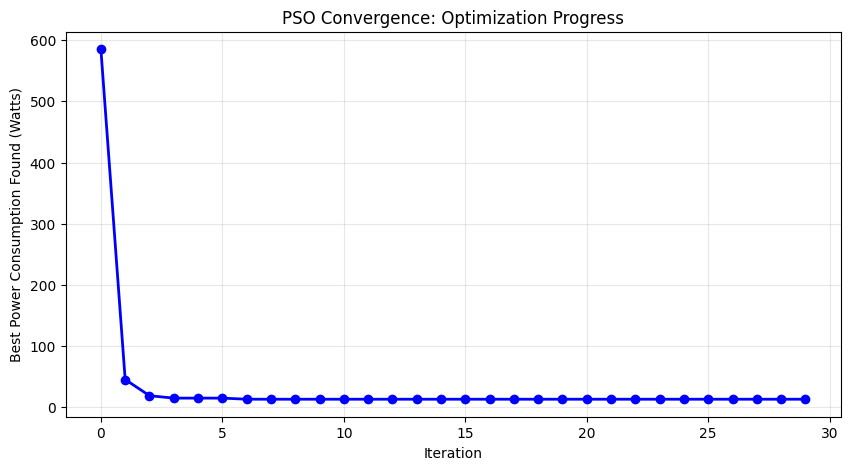

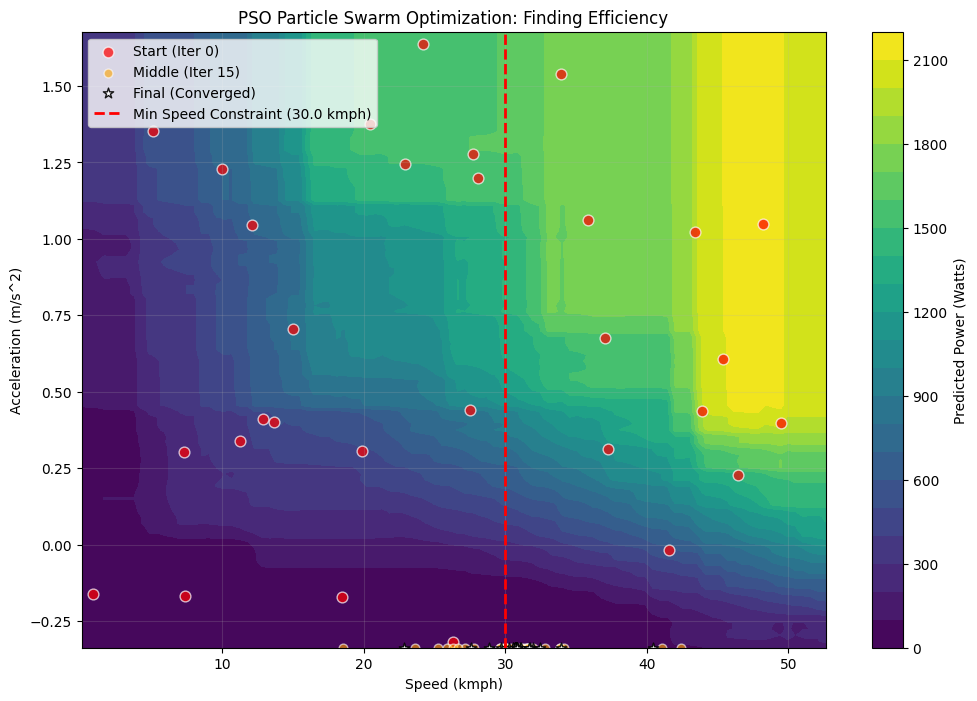

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. MODIFIED PSO CLASS (STORES HISTORY)
# ==========================================
# We need to modify the PSO class slightly to save the positions
# of particles at every step so we can plot them later.
class PSO_Visualizer:
    def __init__(self, objective_func, bounds, num_particles=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = len(bounds)

        # History containers for plotting
        self.history_gbest_score = [] # Best score found at each iteration
        self.history_positions = []   # All particle positions at each iteration

    def optimize(self):
        # Initialize
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.num_particles, self.dim))
        V = np.random.uniform(-1, 1, size=(self.num_particles, self.dim))

        P_best_pos = X.copy()
        P_best_score = np.array([self.func(p) for p in X])

        gbest_idx = np.argmin(P_best_score)
        G_best_pos = P_best_pos[gbest_idx].copy()
        G_best_score = P_best_score[gbest_idx]

        w, c1, c2 = 0.7, 1.5, 1.5 # Standard PSO weights

        for i in range(self.max_iter):
            # SAVE HISTORY
            self.history_positions.append(X.copy())
            self.history_gbest_score.append(G_best_score)

            # PSO Update Steps
            r1 = np.random.rand(self.num_particles, self.dim)
            r2 = np.random.rand(self.num_particles, self.dim)
            V = (w * V) + (c1 * r1 * (P_best_pos - X)) + (c2 * r2 * (G_best_pos - X))
            X = X + V

            # Clip bounds
            for d in range(self.dim):
                X[:, d] = np.clip(X[:, d], self.bounds[d, 0], self.bounds[d, 1])

            # Evaluate
            scores = np.array([self.func(p) for p in X])

            # Update Personal Best
            better_mask = scores < P_best_score
            P_best_pos[better_mask] = X[better_mask]
            P_best_score[better_mask] = scores[better_mask]

            # Update Global Best
            if np.min(scores) < G_best_score:
                min_idx = np.argmin(scores)
                G_best_pos = X[min_idx].copy()
                G_best_score = scores[min_idx]

        return G_best_pos, G_best_score

# ==========================================
# 2. RUN OPTIMIZATION
# ==========================================
# (Assuming 'objective_function' and 'bounds' are defined as in the previous code)
pso_viz = PSO_Visualizer(objective_function, bounds, num_particles=30, max_iter=30)
best_pos, best_score = pso_viz.optimize()

print(f"Optimization Complete. Best Power: {best_score:.2f} W")

# ==========================================
# 3. GENERATE PLOTS
# ==========================================

# --- PLOT A: Convergence Curve ---
plt.figure(figsize=(10, 5))
plt.plot(pso_viz.history_gbest_score, marker='o', linestyle='-', color='b', linewidth=2)
plt.title('PSO Convergence: Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Best Power Consumption Found (Watts)')
plt.grid(True, alpha=0.3)
plt.show()

# --- PLOT B: Search Landscape (Contour Plot) ---
plt.figure(figsize=(12, 8))

# 1. Create a background grid representing the "Physics" (Power Consumption)
# We use the bounds we defined earlier
x_grid = np.linspace(bounds[0,0], bounds[0,1], 100) # Speed Range
y_grid = np.linspace(bounds[1,0], bounds[1,1], 100) # Accel Range
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

# Flatten to feed into our Random Forest Model
mesh_points = np.c_[X_mesh.ravel(), Y_mesh.ravel()]
# Predict Power for every point on the grid
Z_mesh = power_model.predict(mesh_points).reshape(X_mesh.shape)

# 2. Draw the Contour
cp = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels=25, cmap='viridis')
plt.colorbar(cp, label='Predicted Power (Watts)')

# 3. Overlay Particles (Start vs End)
# Plot Initial Positions (Red)
initial_pos = pso_viz.history_positions[0]
plt.scatter(initial_pos[:, 0], initial_pos[:, 1], c='red', label='Start (Iter 0)', alpha=0.7, edgecolors='white', s=60)

# Plot Middle Positions (Orange) - Optional
mid_idx = len(pso_viz.history_positions) // 2
mid_pos = pso_viz.history_positions[mid_idx]
plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='orange', label=f'Middle (Iter {mid_idx})', alpha=0.6, edgecolors='white', s=40)

# Plot Final Positions (White)
final_pos = pso_viz.history_positions[-1]
plt.scatter(final_pos[:, 0], final_pos[:, 1], c='white', label='Final (Converged)', alpha=0.9, edgecolors='black', s=60, marker='*')

# 4. Mark the Constraints
plt.axvline(x=TARGET_MIN_SPEED, color='red', linestyle='--', linewidth=2, label=f'Min Speed Constraint ({TARGET_MIN_SPEED} kmph)')

plt.title('PSO Particle Swarm Optimization: Finding Efficiency')
plt.xlabel('Speed (kmph)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ==========================================
# 1. SETUP & MODEL TRAINING
# ==========================================
# Load your data
df = pd.read_excel('/content/Test125.xlsx') # Corrected: changed to read_excel and correct path
df_clean = df[df['Actual Power'] > 0].copy()
X = df_clean[['kmph_f', 'Acc_fil']].values
y = df_clean['Actual Power'].values

# Train the Surrogate Model (The "Physics Engine")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Define Bounds
min_speed, max_speed = df_clean['kmph_f'].min(), df_clean['kmph_f'].max()
min_acc, max_acc = df_clean['Acc_fil'].min(), df_clean['Acc_fil'].max()
bounds = np.array([[min_speed, max_speed], [min_acc, max_acc]])

# Define Objective
TARGET_MIN_SPEED = 30.0
def objective_function(x):
    speed, accel = x[0], x[1]
    penalty = 0
    if speed < TARGET_MIN_SPEED:
        # Reduced penalty multiplier to allow "softer" boundaries initially
        penalty = 5000 * (TARGET_MIN_SPEED - speed)
    
    # Predict power
    pred_power = model.predict([[speed, accel]])[0]
    return pred_power + penalty

# ==========================================
# 2. PSO WITH EXPLORATION TUNING
# ==========================================
class PSO_Robust:
    def __init__(self, objective_func, bounds, num_particles=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = len(bounds)
        self.history_gbest = []

    def optimize(self):
        # 1. Initialize Particles randomly
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.num_particles, self.dim))
        
        # 2. Initialize Velocities
        V = np.random.uniform(-1, 1, size=(self.num_particles, self.dim))
        
        # 3. SET VELOCITY LIMITS (Crucial for slower convergence)
        # Limit max step size to 20% of the total range
        v_max = (self.bounds[:, 1] - self.bounds[:, 0]) * 0.2
        
        P_best_pos = X.copy()
        P_best_score = np.array([self.func(p) for p in X])
        
        gbest_idx = np.argmin(P_best_score)
        G_best_pos = P_best_pos[gbest_idx].copy()
        G_best_score = P_best_score[gbest_idx]
        
        # 4. DYNAMIC HYPERPARAMETERS
        w_start = 0.9  # High inertia (explore)
        w_end = 0.4    # Low inertia (exploit/settle)
        c1 = 2.0       # Trust Self (Exploration)
        c2 = 1.0       # Trust Group (Exploitation) - Lowered to prevent rushing

        print("Starting Robust PSO...")
        for i in range(self.max_iter):
            self.history_gbest.append(G_best_score)
            
            # Linear Decay of Inertia (w)
            w = w_start - ((w_start - w_end) * i / self.max_iter)
            
            r1 = np.random.rand(self.num_particles, self.dim)
            r2 = np.random.rand(self.num_particles, self.dim)
            
            # Update Velocity
            V = (w * V) + (c1 * r1 * (P_best_pos - X)) + (c2 * r2 * (G_best_pos - X))
            
            # Apply Velocity Clamping (Prevent teleporting)
            for d in range(self.dim):
                V[:, d] = np.clip(V[:, d], -v_max[d], v_max[d])
            
            # Update Position
            X = X + V
            
            # Boundary Handling
            for d in range(self.dim):
                X[:, d] = np.clip(X[:, d], self.bounds[d, 0], self.bounds[d, 1])
            
            # Evaluate
            scores = np.array([self.func(p) for p in X])
            
            # Update Personal Best
            better_mask = scores < P_best_score
            P_best_pos[better_mask] = X[better_mask]
            P_best_score[better_mask] = scores[better_mask]
            
            # Update Global Best
            if np.min(scores) < G_best_score:
                min_idx = np.argmin(scores)
                G_best_pos = X[min_idx].copy()
                G_best_score = scores[min_idx]
                # print(f"Iter {i}: New Best Found -> {G_best_score:.2f}")

        return G_best_pos, G_best_score, self.history_gbest

# ==========================================
# 3. RUN AND PLOT
# ==========================================
pso = PSO_Robust(objective_function, bounds, num_particles=30, max_iter=50)
best_pos, best_score, history = pso.optimize()

print(f"Optimal Speed: {best_pos[0]:.2f} kmph")
print(f"Optimal Accel: {best_pos[1]:.4f} m/s^2")

# Plot Convergence
plt.figure(figsize=(10, 6))
plt.plot(history, marker='o', linewidth=2, color='royalblue')
plt.title('PSO Convergence (Slower, More Robust)', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Power Consumption (Watts)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Starting Robust PSO...
Optimal Speed: 30.74 kmph
Optimal Accel: -0.3364 m/s^2


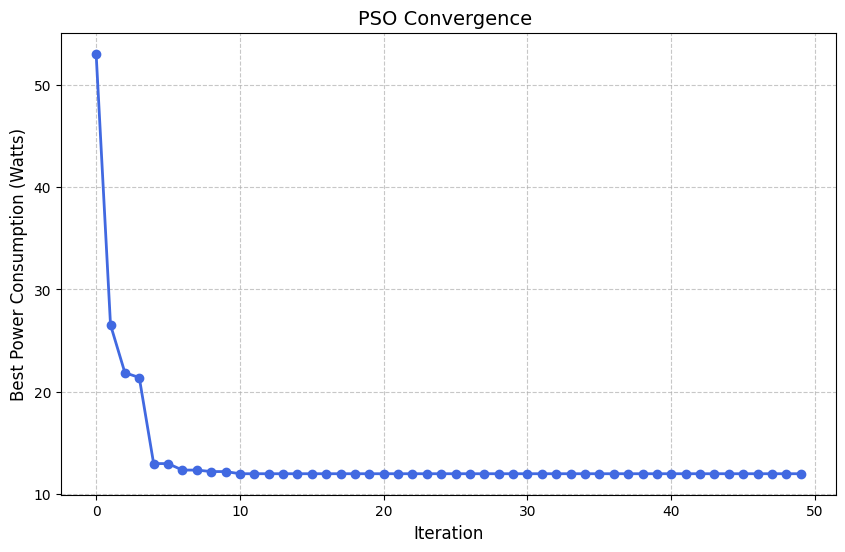

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ==========================================
# 1. SETUP & MODEL TRAINING
# ==========================================
# Load your data
df = pd.read_excel('/content/Test125.xlsx')
df_clean = df[df['Actual Power'] > 0].copy()
X = df_clean[['kmph_f', 'Acc_fil']].values
y = df_clean['Actual Power'].values

# Train the Surrogate Model (The "Physics Engine")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Define Bounds
min_speed, max_speed = df_clean['kmph_f'].min(), df_clean['kmph_f'].max()
min_acc, max_acc = df_clean['Acc_fil'].min(), df_clean['Acc_fil'].max()
bounds = np.array([[min_speed, max_speed], [min_acc, max_acc]])

# Define Objective
TARGET_MIN_SPEED = 30.0
def objective_function(x):
    speed, accel = x[0], x[1]
    penalty = 0
    if speed < TARGET_MIN_SPEED:
        # Reduced penalty multiplier to allow "softer" boundaries initially
        penalty = 5000 * (TARGET_MIN_SPEED - speed)

    # Predict power
    pred_power = model.predict([[speed, accel]])[0]
    return pred_power + penalty

# ==========================================
# 2. PSO WITH EXPLORATION TUNING
# ==========================================
class PSO_Robust:
    def __init__(self, objective_func, bounds, num_particles=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = len(bounds)
        self.history_gbest = []

    def optimize(self):
        # 1. Initialize Particles randomly
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.num_particles, self.dim))

        # 2. Initialize Velocities
        V = np.random.uniform(-1, 1, size=(self.num_particles, self.dim))

        # 3. SET VELOCITY LIMITS (Crucial for slower convergence)
        # Limit max step size to 20% of the total range
        v_max = (self.bounds[:, 1] - self.bounds[:, 0]) * 0.2

        P_best_pos = X.copy()
        P_best_score = np.array([self.func(p) for p in X])

        gbest_idx = np.argmin(P_best_score)
        G_best_pos = P_best_pos[gbest_idx].copy()
        G_best_score = P_best_score[gbest_idx]

        # 4. DYNAMIC HYPERPARAMETERS
        w_start = 0.9  # High inertia (explore)
        w_end = 0.4    # Low inertia (exploit/settle)
        c1 = 2.0       # Trust Self (Exploration)
        c2 = 1.0       # Trust Group (Exploitation) - Lowered to prevent rushing

        print("Starting Robust PSO...")
        for i in range(self.max_iter):
            self.history_gbest.append(G_best_score)

            # Linear Decay of Inertia (w)
            w = w_start - ((w_start - w_end) * i / self.max_iter)

            r1 = np.random.rand(self.num_particles, self.dim)
            r2 = np.random.rand(self.num_particles, self.dim)

            # Update Velocity
            V = (w * V) + (c1 * r1 * (P_best_pos - X)) + (c2 * r2 * (G_best_pos - X))

            # Apply Velocity Clamping (Prevent teleporting)
            for d in range(self.dim):
                V[:, d] = np.clip(V[:, d], -v_max[d], v_max[d])

            # Update Position
            X = X + V

            # Boundary Handling
            for d in range(self.dim):
                X[:, d] = np.clip(X[:, d], self.bounds[d, 0], self.bounds[d, 1])

            # Evaluate
            scores = np.array([self.func(p) for p in X])

            # Update Personal Best
            better_mask = scores < P_best_score
            P_best_pos[better_mask] = X[better_mask]
            P_best_score[better_mask] = scores[better_mask]

            # Update Global Best
            if np.min(scores) < G_best_score:
                min_idx = np.argmin(scores)
                G_best_pos = X[min_idx].copy()
                G_best_score = scores[min_idx]
                # print(f"Iter {i}: New Best Found -> {G_best_score:.2f}")

        return G_best_pos, G_best_score, self.history_gbest

# ==========================================
# 3. RUN AND PLOT
# ==========================================
pso = PSO_Robust(objective_function, bounds, num_particles=30, max_iter=50)
best_pos, best_score, history = pso.optimize()

print(f"Optimal Speed: {best_pos[0]:.2f} kmph")
print(f"Optimal Accel: {best_pos[1]:.4f} m/s^2")

# Plot Convergence
plt.figure(figsize=(10, 6))
plt.plot(history, marker='o', linewidth=2, color='royalblue')
plt.title('PSO Convergence ', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Power Consumption (Watts)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Training physics model...
Starting Jaya Optimization...
Iter 0: Best Power = 18.27 W
Iter 10: Best Power = 11.99 W
Iter 20: Best Power = 11.99 W

JAYA RESULTS
Optimal Speed: 30.70 kmph
Optimal Accel: -0.3364 m/s^2
Minimum Power: 11.99 W


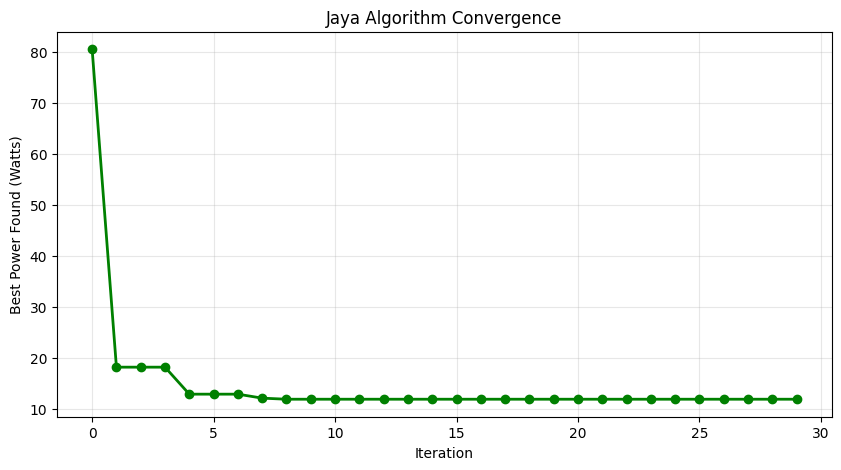

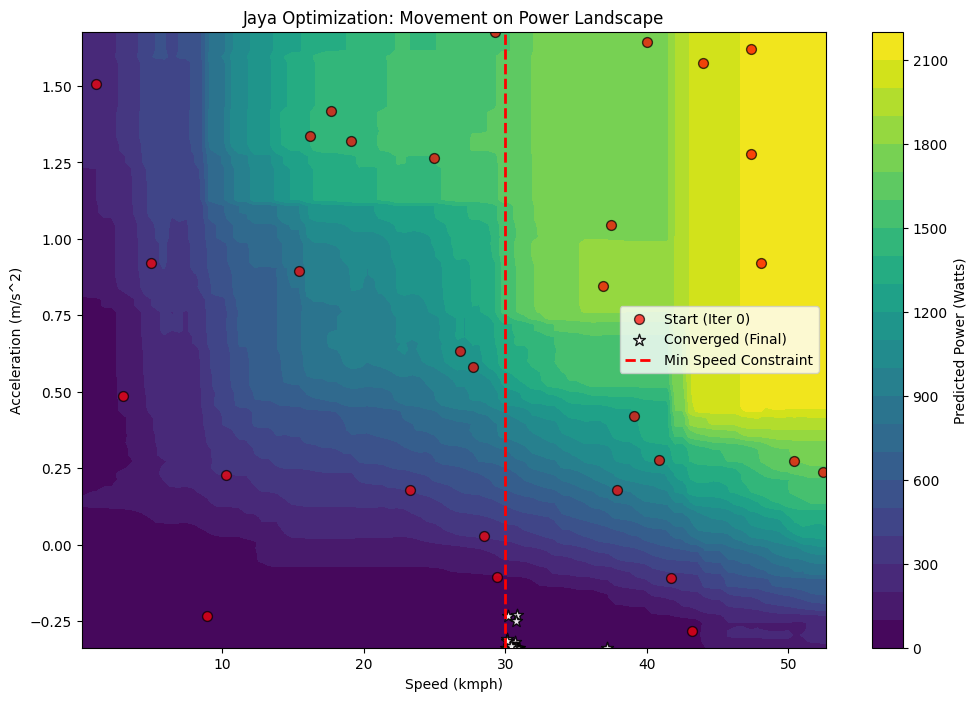

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. PREPARE DATA & MODEL
# ==========================================
# Load Data
df = pd.read_excel('/content/Test125.xlsx')
df_clean = df[df['Actual Power'] > 0].copy() # Filter for driving mode
X = df_clean[['kmph_f', 'Acc_fil']].values
y = df_clean['Actual Power'].values

# Train Surrogate Model (Physics Engine)
print("Training physics model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Define Optimization Bounds
min_speed, max_speed = df_clean['kmph_f'].min(), df_clean['kmph_f'].max()
min_acc, max_acc = df_clean['Acc_fil'].min(), df_clean['Acc_fil'].max()
bounds = np.array([[min_speed, max_speed], [min_acc, max_acc]])

# Define Objective Function
TARGET_MIN_SPEED = 30.0
def objective_function(x):
    speed, accel = x[0], x[1]
    penalty = 0
    if speed < TARGET_MIN_SPEED:
        penalty = 5000 * (TARGET_MIN_SPEED - speed) # Soft constraint

    # Predict power
    pred_power = model.predict([[speed, accel]])[0]
    return pred_power + penalty

# ==========================================
# 2. JAYA ALGORITHM IMPLEMENTATION
# ==========================================
class JayaOptimizer:
    def __init__(self, objective_func, bounds, population_size=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.pop_size = population_size
        self.max_iter = max_iter
        self.dim = len(bounds)

        # History for plotting
        self.history_best_score = []
        self.history_positions = []

    def optimize(self):
        # 1. Initialize Population randomly
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.pop_size, self.dim))

        # 2. Evaluate Initial Population
        fitness = np.array([self.func(ind) for ind in X])

        print("Starting Jaya Optimization...")

        for iteration in range(self.max_iter):
            # Save history
            self.history_positions.append(X.copy())
            best_idx = np.argmin(fitness)
            worst_idx = np.argmax(fitness)
            self.history_best_score.append(fitness[best_idx])

            # Identify Best and Worst candidates
            best_sol = X[best_idx]
            worst_sol = X[worst_idx]

            # Create new population array
            X_new = np.zeros_like(X)

            for i in range(self.pop_size):
                # Generate random numbers r1, r2 for stochasticity
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)

                # JAYA UPDATE EQUATION:
                # New = Old + r1 * (Best - |Old|) - r2 * (Worst - |Old|)
                # Moves towards Best, moves away from Worst
                term1 = r1 * (best_sol - np.abs(X[i]))
                term2 = r2 * (worst_sol - np.abs(X[i]))

                X_new[i] = X[i] + term1 - term2

                # Clip to bounds (Safety)
                X_new[i] = np.clip(X_new[i], self.bounds[:, 0], self.bounds[:, 1])

            # Greedy Selection Strategy
            # Only keep the new position if it's better than the old one
            fitness_new = np.array([self.func(ind) for ind in X_new])

            # Mask where new is better than old
            better_mask = fitness_new < fitness

            # Update population and fitness
            X[better_mask] = X_new[better_mask]
            fitness[better_mask] = fitness_new[better_mask]

            if iteration % 10 == 0:
                print(f"Iter {iteration}: Best Power = {fitness[np.argmin(fitness)]:.2f} W")

        # Final Result
        final_best_idx = np.argmin(fitness)
        return X[final_best_idx], fitness[final_best_idx]

# ==========================================
# 3. RUN OPTIMIZATION
# ==========================================
jaya = JayaOptimizer(objective_function, bounds, population_size=30, max_iter=30)
best_params, min_power = jaya.optimize()

print("\n" + "="*30)
print(f"JAYA RESULTS")
print("="*30)
print(f"Optimal Speed: {best_params[0]:.2f} kmph")
print(f"Optimal Accel: {best_params[1]:.4f} m/s^2")
print(f"Minimum Power: {min_power:.2f} W")

# ==========================================
# 4. PLOTTING
# ==========================================

# --- A. Convergence Plot ---
plt.figure(figsize=(10, 5))
plt.plot(jaya.history_best_score, marker='o', linestyle='-', color='green', linewidth=2)
plt.title('Jaya Algorithm Convergence')
plt.xlabel('Iteration')
plt.ylabel('Best Power Found (Watts)')
plt.grid(True, alpha=0.3)
plt.show()

# --- B. Search Landscape Plot ---
plt.figure(figsize=(12, 8))

# Background Grid (Physics Model)
x_grid = np.linspace(bounds[0,0], bounds[0,1], 100)
y_grid = np.linspace(bounds[1,0], bounds[1,1], 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
mesh_points = np.c_[X_mesh.ravel(), Y_mesh.ravel()]
Z_mesh = model.predict(mesh_points).reshape(X_mesh.shape)

# Contour Plot
cp = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels=25, cmap='viridis')
plt.colorbar(cp, label='Predicted Power (Watts)')

# Overlay Particles
# Start (Red Circles)
start_pos = jaya.history_positions[0]
plt.scatter(start_pos[:, 0], start_pos[:, 1], c='red', label='Start (Iter 0)', alpha=0.7, edgecolors='black', s=50)

# End (White Stars)
end_pos = jaya.history_positions[-1]
plt.scatter(end_pos[:, 0], end_pos[:, 1], c='white', label='Converged (Final)', alpha=0.9, edgecolors='black', marker='*', s=80)

# Constraint Line
plt.axvline(x=TARGET_MIN_SPEED, color='red', linestyle='--', linewidth=2, label='Min Speed Constraint')

plt.title('Jaya Optimization: Movement on Power Landscape')
plt.xlabel('Speed (kmph)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()

Training Physics Model for Torque...
Starting Optimization...

TORQUE OPTIMIZATION RESULTS
Optimal Speed:        37.26 kmph
Optimal Acceleration: -0.3364 m/s^2
Minimized Torque:     0.21 Ft*Rr


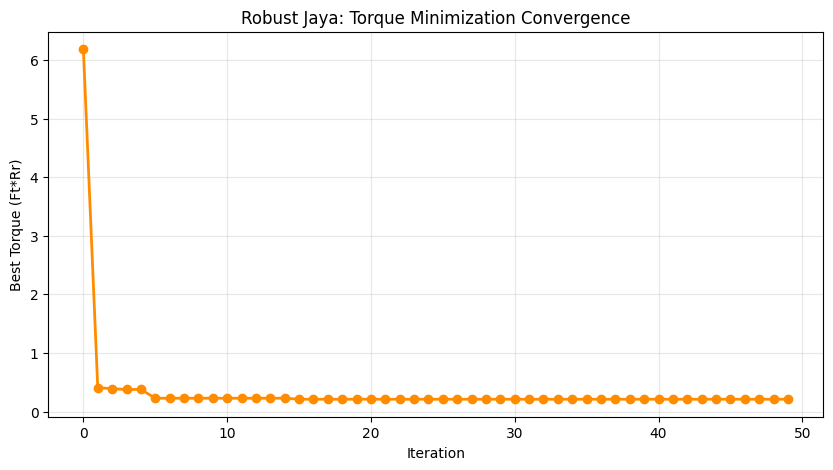

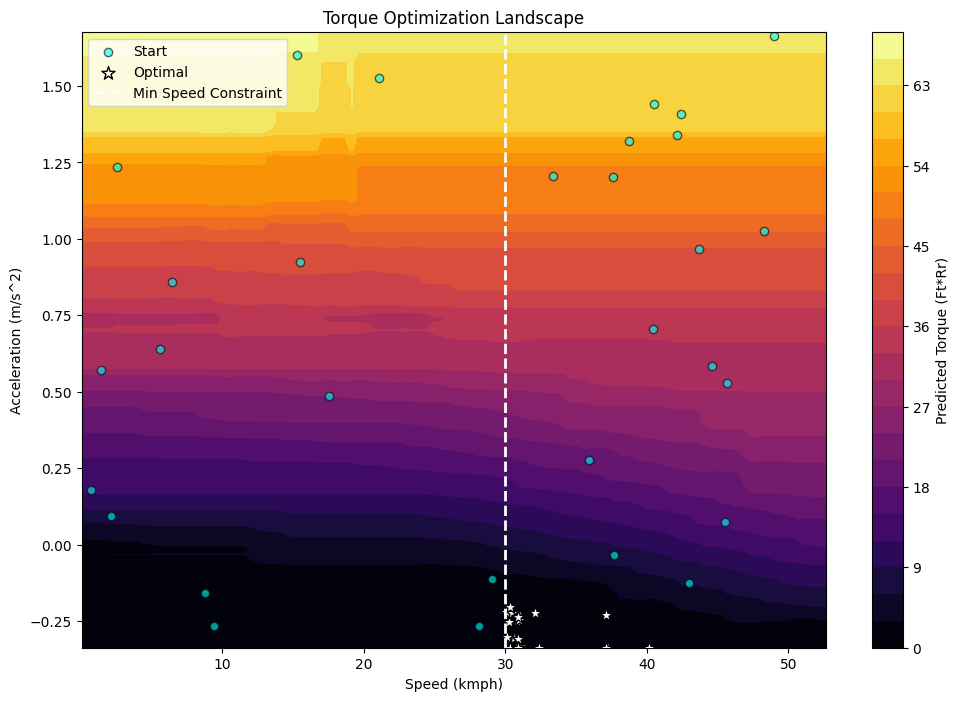

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. DATA PREPARATION (TARGETING TORQUE)
# ==========================================
# Load Data
filename = '/content/Test125.xlsx' # Corrected filename and path
df = pd.read_excel(filename) # Changed to read_excel

# Filter: We only want to optimize Torque during active driving (Motoring)
# Using Power > 0 is a good proxy for "Engine is working"
df_clean = df[df['Actual Power'] > 0].copy()

# Inputs: Speed and Acceleration
X = df_clean[['kmph_f', 'Acc_fil']].values

# Output: TORQUE (This is the change)
y = df_clean['TORQUE(Ft*Rr)'].values

print("Training Physics Model for Torque...")
# Train the surrogate model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Bounds for optimization
min_speed, max_speed = df_clean['kmph_f'].min(), df_clean['kmph_f'].max()
min_acc, max_acc = df_clean['Acc_fil'].min(), df_clean['Acc_fil'].max()
bounds = np.array([[min_speed, max_speed], [min_acc, max_acc]])

# ==========================================
# 2. OBJECTIVE FUNCTION (MINIMIZE TORQUE)
# ==========================================
TARGET_MIN_SPEED = 30.0 # Constraint: Keep car moving

def objective_function(x):
    speed, accel = x[0], x[1]

    # Penalty for going too slow (Soft Constraint)
    penalty = 0
    if speed < TARGET_MIN_SPEED:
        # High penalty ensures algorithm prefers meeting speed target
        penalty = 1000 * (TARGET_MIN_SPEED - speed)

    # Predict TORQUE instead of Power
    # Note: If Torque can be negative (braking), and you only want to minimize
    # MAGNITUDE, use abs(pred). If simple minimization, use pred.
    # Assuming positive torque consumes energy:
    pred_torque = model.predict([[speed, accel]])[0]

    # We return Torque + Penalty
    return pred_torque + penalty

# ==========================================
# 3. ROBUST JAYA OPTIMIZER CLASS
# ==========================================
class RobustJayaOptimizer:
    def __init__(self, objective_func, bounds, population_size=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.pop_size = population_size
        self.max_iter = max_iter
        self.dim = len(bounds)
        self.history_best_score = []
        self.history_positions = []

    def optimize(self):
        # Initialize Population
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.pop_size, self.dim))
        fitness = np.array([self.func(ind) for ind in X])

        # Robust Scale Parameters (Damping)
        scale_start = 0.2
        scale_end = 1.0

        print("Starting Optimization...")
        for iteration in range(self.max_iter):
            # Save History
            self.history_positions.append(X.copy())
            best_idx = np.argmin(fitness)
            self.history_best_score.append(fitness[best_idx])

            best_sol = X[best_idx]
            worst_sol = X[np.argmax(fitness)]

            # Calculate Dynamic Scale
            current_scale = scale_start + ((scale_end - scale_start) * (iteration / self.max_iter))

            X_new = np.zeros_like(X)

            for i in range(self.pop_size):
                r1 = np.random.rand(self.dim)
                r2 = np.random.rand(self.dim)

                # Robust Update Equation
                term1 = r1 * (best_sol - np.abs(X[i]))
                term2 = r2 * (worst_sol - np.abs(X[i]))

                # Apply Scale
                step = (term1 - term2) * current_scale
                X_new[i] = X[i] + step

                # Clip Bounds
                X_new[i] = np.clip(X_new[i], self.bounds[:, 0], self.bounds[:, 1])

            # Greedy Selection
            fitness_new = np.array([self.func(ind) for ind in X_new])
            mask = fitness_new < fitness
            X[mask] = X_new[mask]
            fitness[mask] = fitness_new[mask]

        return X[np.argmin(fitness)], fitness[np.argmin(fitness)]

# ==========================================
# 4. RUN AND VISUALIZE
# ==========================================
jaya = RobustJayaOptimizer(objective_function, bounds, population_size=30, max_iter=50)
best_params, min_torque = jaya.optimize()

print("\n" + "="*35)
print("TORQUE OPTIMIZATION RESULTS")
print("="*35)
print(f"Optimal Speed:        {best_params[0]:.2f} kmph")
print(f"Optimal Acceleration: {best_params[1]:.4f} m/s^2")
print(f"Minimized Torque:     {min_torque:.2f} Ft*Rr")
print("="*35)

# --- Plot 1: Convergence ---
plt.figure(figsize=(10, 5))
plt.plot(jaya.history_best_score, marker='o', color='darkorange', linewidth=2)
plt.title('Robust Jaya: Torque Minimization Convergence')
plt.xlabel('Iteration')
plt.ylabel('Best Torque (Ft*Rr)')
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Torque Landscape ---
plt.figure(figsize=(12, 8))

# Generate Grid
x_grid = np.linspace(bounds[0,0], bounds[0,1], 100)
y_grid = np.linspace(bounds[1,0], bounds[1,1], 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
mesh_points = np.c_[X_mesh.ravel(), Y_mesh.ravel()]
Z_mesh = model.predict(mesh_points).reshape(X_mesh.shape)

# Contour Plot
cp = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels=25, cmap='inferno') # 'inferno' looks good for heat/torque
plt.colorbar(cp, label='Predicted Torque (Ft*Rr)')

# Overlay Particles
start_pos = jaya.history_positions[0]
end_pos = jaya.history_positions[-1]

plt.scatter(start_pos[:, 0], start_pos[:, 1], c='cyan', label='Start', alpha=0.6, edgecolors='black')
plt.scatter(end_pos[:, 0], end_pos[:, 1], c='white', label='Optimal', alpha=1.0, edgecolors='black', marker='*', s=100)

plt.axvline(x=TARGET_MIN_SPEED, color='white', linestyle='--', linewidth=2, label='Min Speed Constraint')
plt.title('Torque Optimization Landscape')
plt.xlabel('Speed (kmph)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()

Training Physics Model for Torque...
Starting Robust PSO for Torque (50 iterations)...
Iter 0: Best Torque = 0.30 Ft*Rr
Iter 10: Best Torque = 0.21 Ft*Rr
Iter 20: Best Torque = 0.21 Ft*Rr
Iter 30: Best Torque = 0.20 Ft*Rr
Iter 40: Best Torque = 0.20 Ft*Rr

PSO TORQUE RESULTS
Optimal Speed:        37.27 kmph
Optimal Acceleration: -0.3150 m/s^2
Minimum Torque:       0.20 Ft*Rr


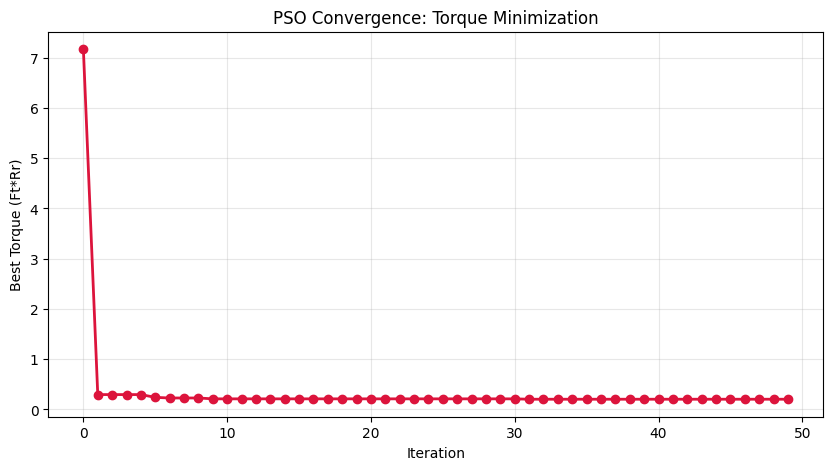

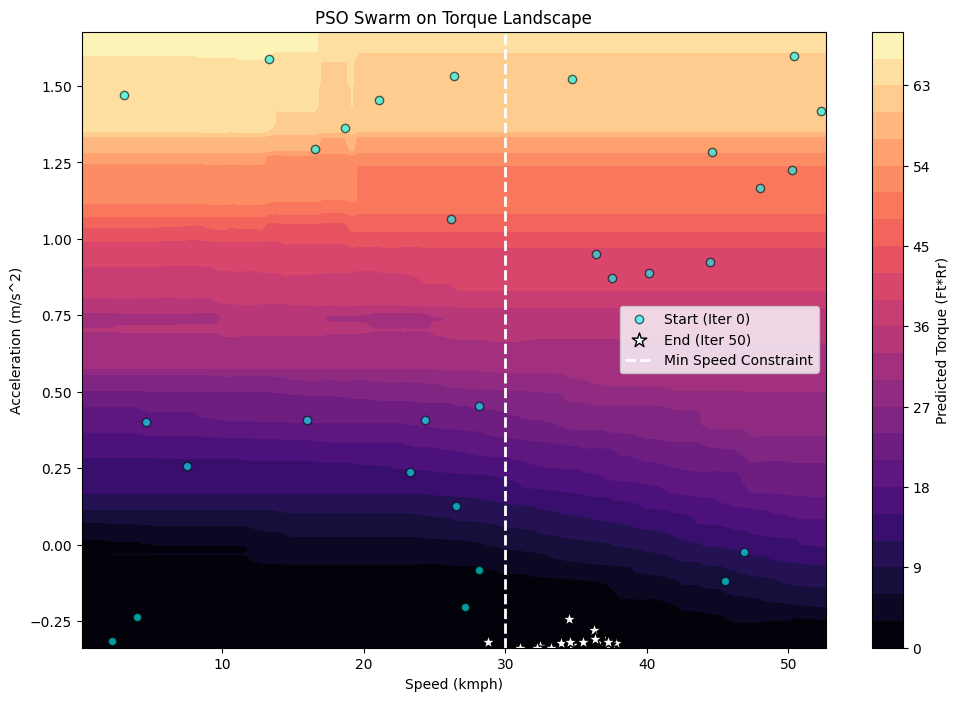

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. DATA PREPARATION (Targeting Torque)
# ==========================================
filename = '/content/Test125.xlsx'
df = pd.read_excel(filename)

# Filter: We optimize for active driving (Power > 0)
df_clean = df[df['Actual Power'] > 0].copy()

# Inputs: Speed (kmph_f) and Acceleration (Acc_fil)
X = df_clean[['kmph_f', 'Acc_fil']].values

# Output: TORQUE (Ft*Rr)
y = df_clean['TORQUE(Ft*Rr)'].values

print("Training Physics Model for Torque...")
# Train the surrogate model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Define Bounds based on real data
min_speed, max_speed = df_clean['kmph_f'].min(), df_clean['kmph_f'].max()
min_acc, max_acc = df_clean['Acc_fil'].min(), df_clean['Acc_fil'].max()
bounds = np.array([[min_speed, max_speed], [min_acc, max_acc]])

# ==========================================
# 2. OBJECTIVE FUNCTION (Minimize Torque)
# ==========================================
TARGET_MIN_SPEED = 30.0 # Constraint: Maintain cruising speed

def objective_function(x):
    speed, accel = x[0], x[1]

    # Penalty for going too slow
    penalty = 0
    if speed < TARGET_MIN_SPEED:
        # Penalty increases as speed drops below 30
        penalty = 2000 * (TARGET_MIN_SPEED - speed)

    # Predict TORQUE
    # We use abs() in case torque is negative (braking/regen),
    # assuming we want to minimize the magnitude of force required.
    # If strictly optimizing drive torque, ensure y values are positive.
    pred_torque = model.predict([[speed, accel]])[0]

    return pred_torque + penalty

# ==========================================
# 3. ROBUST PSO OPTIMIZER CLASS
# ==========================================
class RobustPSO:
    def __init__(self, objective_func, bounds, num_particles=30, max_iter=50):
        self.func = objective_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = len(bounds)

        # History for plotting
        self.history_gbest = []
        self.history_positions = []

    def optimize(self):
        # 1. Initialize Particles
        X = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(self.num_particles, self.dim))
        V = np.random.uniform(-1, 1, size=(self.num_particles, self.dim))

        # 2. Set Robust Parameters
        # Max velocity = 20% of the map size (Prevents teleporting)
        v_max = (self.bounds[:, 1] - self.bounds[:, 0]) * 0.2

        # Inertia (w): Starts high (exploration) -> ends low (exploitation)
        w_start = 0.9
        w_end = 0.4
        c1 = 2.0  # Cognitive (Self)
        c2 = 1.0  # Social (Swarm) - Lower c2 prevents premature convergence

        # 3. Evaluate Initial State
        P_best_pos = X.copy()
        P_best_score = np.array([self.func(p) for p in X])

        gbest_idx = np.argmin(P_best_score)
        G_best_pos = P_best_pos[gbest_idx].copy()
        G_best_score = P_best_score[gbest_idx]

        print(f"Starting Robust PSO for Torque ({self.max_iter} iterations)...")

        for i in range(self.max_iter):
            self.history_positions.append(X.copy())
            self.history_gbest.append(G_best_score)

            # Dynamic Inertia
            w = w_start - ((w_start - w_end) * i / self.max_iter)

            # Random factors
            r1 = np.random.rand(self.num_particles, self.dim)
            r2 = np.random.rand(self.num_particles, self.dim)

            # Update Velocity
            V = (w * V) + (c1 * r1 * (P_best_pos - X)) + (c2 * r2 * (G_best_pos - X))

            # Velocity Clamping
            for d in range(self.dim):
                V[:, d] = np.clip(V[:, d], -v_max[d], v_max[d])

            # Update Position
            X = X + V

            # Boundary Clamping
            for d in range(self.dim):
                X[:, d] = np.clip(X[:, d], self.bounds[d, 0], self.bounds[d, 1])

            # Evaluation
            scores = np.array([self.func(p) for p in X])

            # Update Personal Best
            better_mask = scores < P_best_score
            P_best_pos[better_mask] = X[better_mask]
            P_best_score[better_mask] = scores[better_mask]

            # Update Global Best
            if np.min(scores) < G_best_score:
                min_idx = np.argmin(scores)
                G_best_pos = X[min_idx].copy()
                G_best_score = scores[min_idx]

            if i % 10 == 0:
                 print(f"Iter {i}: Best Torque = {G_best_score:.2f} Ft*Rr")

        return G_best_pos, G_best_score

# ==========================================
# 4. EXECUTE & VISUALIZE
# ==========================================
pso = RobustPSO(objective_function, bounds, num_particles=30, max_iter=50)
best_pos, min_torque = pso.optimize()

print("\n" + "="*35)
print("PSO TORQUE RESULTS")
print("="*35)
print(f"Optimal Speed:        {best_pos[0]:.2f} kmph")
print(f"Optimal Acceleration: {best_pos[1]:.4f} m/s^2")
print(f"Minimum Torque:       {min_torque:.2f} Ft*Rr")
print("="*35)

# --- Plot 1: Convergence ---
plt.figure(figsize=(10, 5))
plt.plot(pso.history_gbest, marker='o', color='crimson', linewidth=2)
plt.title('PSO Convergence: Torque Minimization')
plt.xlabel('Iteration')
plt.ylabel('Best Torque (Ft*Rr)')
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Landscape ---
plt.figure(figsize=(12, 8))

# Grid
x_grid = np.linspace(bounds[0,0], bounds[0,1], 100)
y_grid = np.linspace(bounds[1,0], bounds[1,1], 100)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
mesh_points = np.c_[X_mesh.ravel(), Y_mesh.ravel()]
Z_mesh = model.predict(mesh_points).reshape(X_mesh.shape)

# Contour
cp = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels=25, cmap='magma')
plt.colorbar(cp, label='Predicted Torque (Ft*Rr)')

# Particles
start_pos = pso.history_positions[0]
end_pos = pso.history_positions[-1]

plt.scatter(start_pos[:, 0], start_pos[:, 1], c='cyan', label='Start (Iter 0)', alpha=0.6, edgecolors='black')
plt.scatter(end_pos[:, 0], end_pos[:, 1], c='white', label='End (Iter 50)', alpha=1.0, edgecolors='black', marker='*', s=120)

plt.axvline(x=TARGET_MIN_SPEED, color='white', linestyle='--', linewidth=2, label='Min Speed Constraint')
plt.title('PSO Swarm on Torque Landscape')
plt.xlabel('Speed (kmph)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()


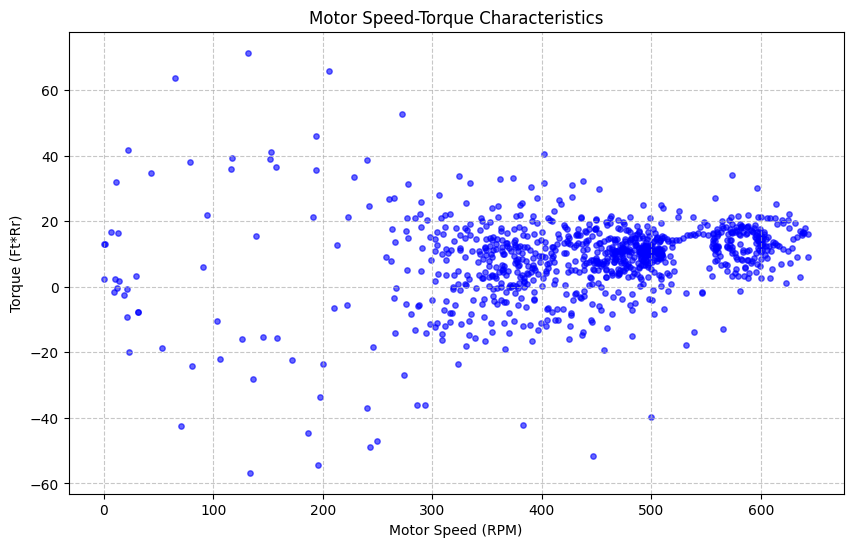

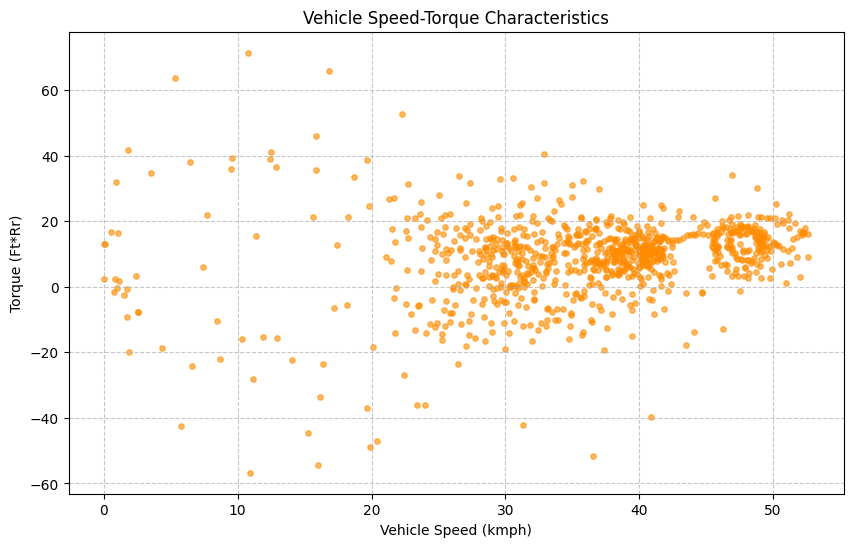

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_excel('/content/Test125.xlsx') # Corrected to read_excel and proper path

# 2. Plot 1: Motor Speed (RPM) vs Torque
plt.figure(figsize=(10, 6))
plt.scatter(df['RPM'], df['TORQUE(Ft*Rr)'], alpha=0.6, s=15, color='blue')
plt.title('Motor Speed-Torque Characteristics')
plt.xlabel('Motor Speed (RPM)')
plt.ylabel('Torque (Ft*Rr)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. Plot 2: Vehicle Speed (kmph) vs Torque
plt.figure(figsize=(10, 6))
plt.scatter(df['kmph_f'], df['TORQUE(Ft*Rr)'], alpha=0.6, s=15, color='darkorange')
plt.title('Vehicle Speed-Torque Characteristics')
plt.xlabel('Vehicle Speed (kmph)')
plt.ylabel('Torque (Ft*Rr)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



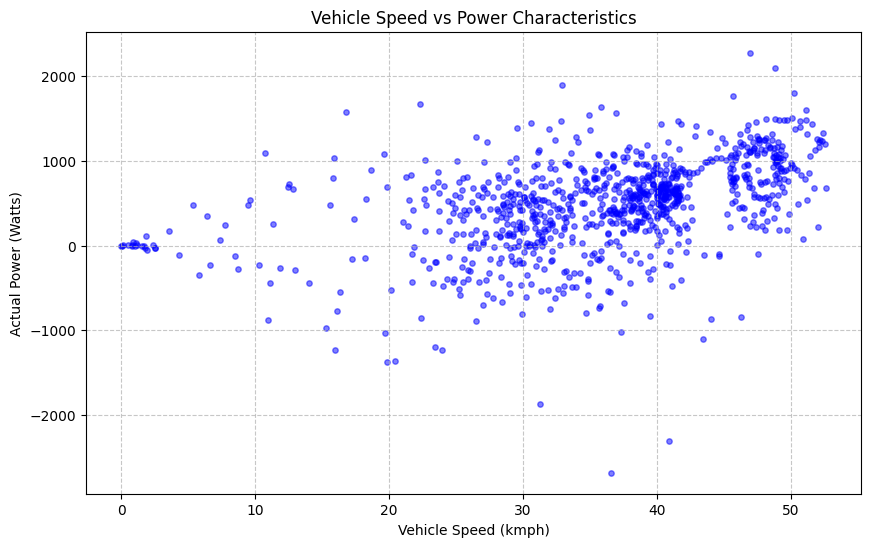

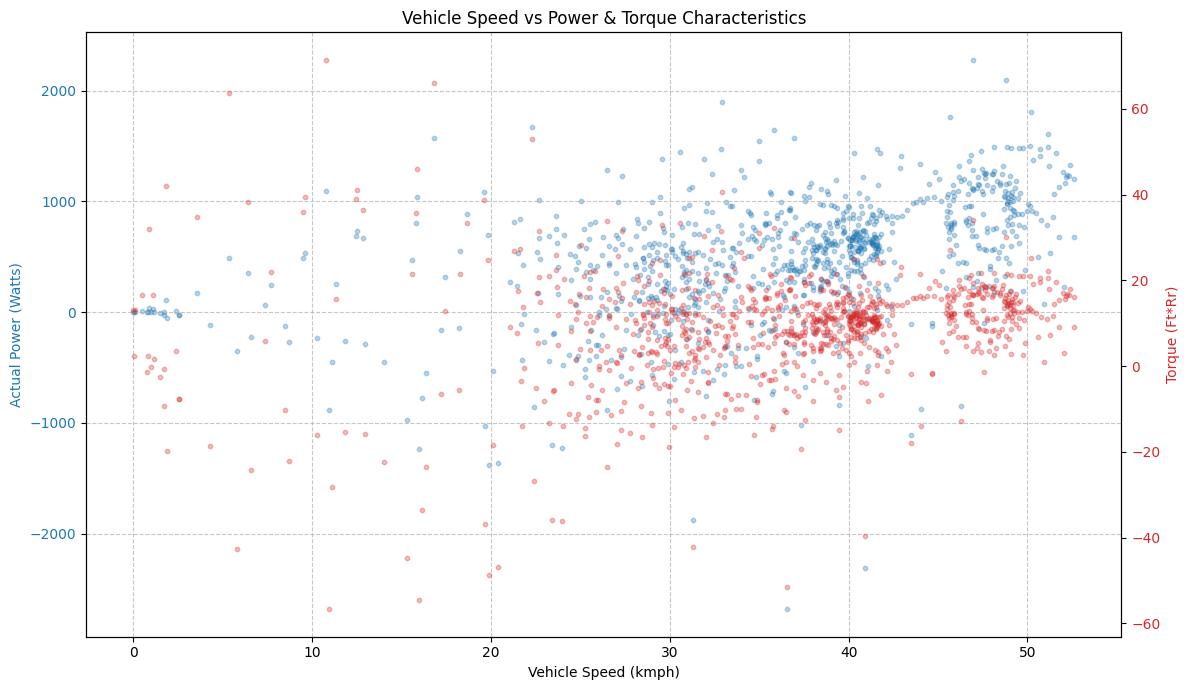

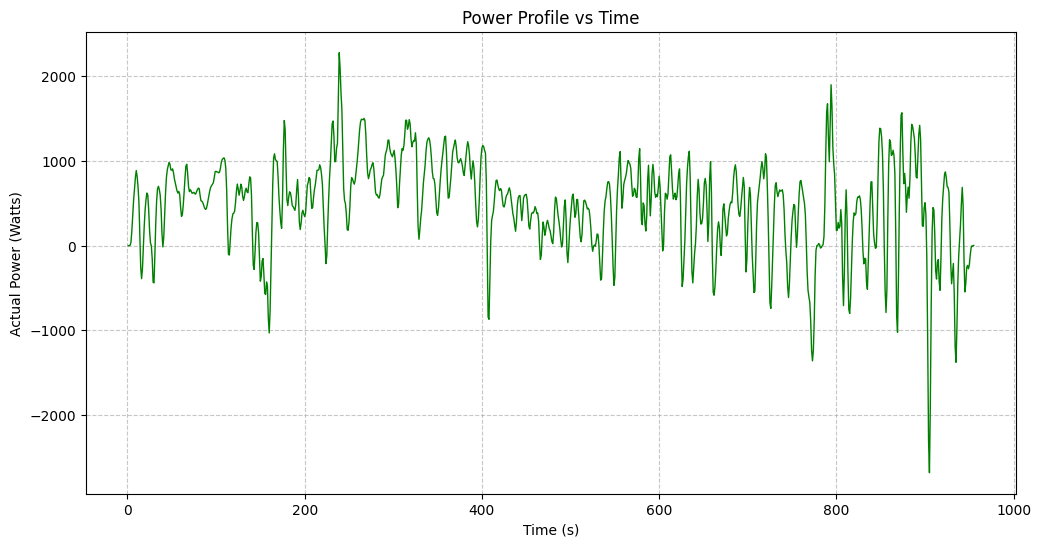

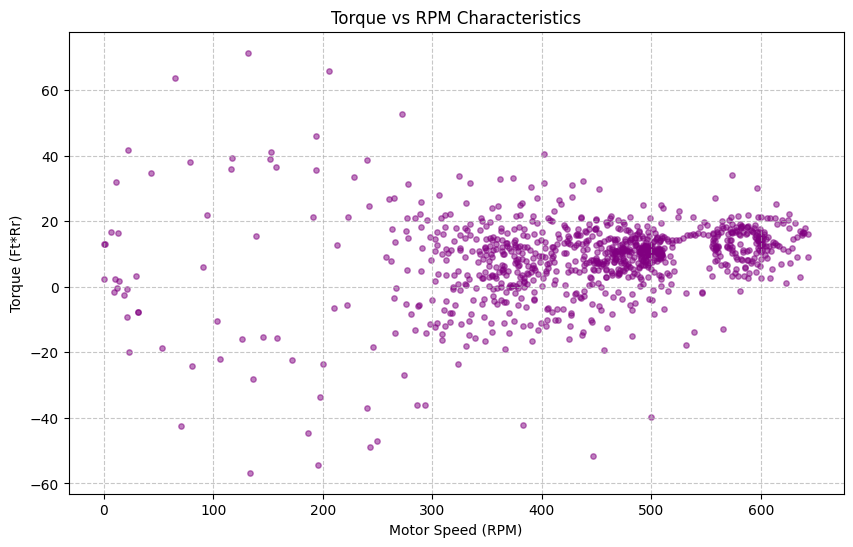

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
df = pd.read_excel('/content/Test125.xlsx')

# --- Plot 1: Speed vs Power ---
plt.figure(figsize=(10, 6))
plt.scatter(df['kmph_f'], df['Actual Power'], alpha=0.5, s=15, color='blue')
plt.title('Vehicle Speed vs Power Characteristics')
plt.xlabel('Vehicle Speed (kmph)')
plt.ylabel('Actual Power (Watts)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('speed_vs_power.png')
plt.show()

# --- Plot 2: Speed vs Power & Torque (Dual Axis) ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Left Axis: Power
color1 = 'tab:blue'
ax1.set_xlabel('Vehicle Speed (kmph)')
ax1.set_ylabel('Actual Power (Watts)', color=color1)
ax1.scatter(df['kmph_f'], df['Actual Power'], color=color1, alpha=0.3, s=10)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.7)

# Right Axis: Torque
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Torque (Ft*Rr)', color=color2)
ax2.scatter(df['kmph_f'], df['TORQUE(Ft*Rr)'], color=color2, alpha=0.3, s=10)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Vehicle Speed vs Power & Torque Characteristics')
plt.tight_layout()
plt.savefig('speed_power_torque_dual.png')
plt.show()

# --- Plot 3: Power vs Time ---
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['Actual Power'], color='green', linewidth=1)
plt.title('Power Profile vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Actual Power (Watts)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('power_vs_time.png')
plt.show()

# --- Plot 4: Torque vs RPM ---
plt.figure(figsize=(10, 6))
plt.scatter(df['RPM'], df['TORQUE(Ft*Rr)'], alpha=0.5, s=15, color='purple')
plt.title('Torque vs RPM Characteristics')
plt.xlabel('Motor Speed (RPM)')
plt.ylabel('Torque (Ft*Rr)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('torque_vs_rpm.png')
plt.show()